tgb - 8/9/2019 - Using the brand new utilites, we will:  
- Calculate surface tension by differentiating the Landau function with respect to the contour for both FMSE and PW

# 1) Initialization

## 1.1) Import utilities

In [151]:
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import datetime
from skimage import measure
from scipy import ndimage
import scipy.integrate as sin
from scipy.optimize import curve_fit

## 1.2) Load simulations

In [8]:
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_206x206/output/'

In [9]:
RCE300 = xr.open_mfdataset(path+'lfff[0-6]???????.nc')

/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


# 2) Surface tension from the Landau function

## 2.1) FMSE

### 2.1.1) Landau free energy

In [10]:
dt = 3600; # Timestep in seconds
tcoor = dt*np.arange(0,RCE300.time.shape[0])

In [11]:
t_range = np.arange(0,np.size(RCE300.time)-2)
dMSE_dt = (RCE300.FMSE.values[t_range+2,:,:]-RCE300.FMSE.values[t_range,:,:])/(2*dt)
dMSE_dt = np.concatenate((dMSE_dt[0:1,:,:],dMSE_dt,np.tile(dMSE_dt[-1,:,:],(1,1,1))),axis=0)

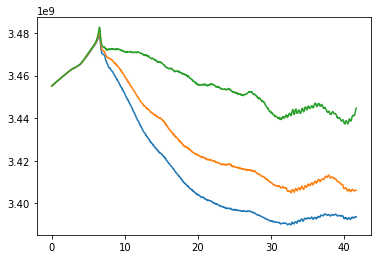

In [20]:
it = np.arange(0,1000)

plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.FMSE[it,:,:],q=25,axis=(1,2)))
plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.FMSE[it,:,:],q=50,axis=(1,2)))
plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.FMSE[it,:,:],q=75,axis=(1,2)))

In [27]:
bin0 = 3.45e9; # 0 value for potential
F,binm,V = Landau.Landau_energy(RCE300.FMSE[24*50:24*60,:,:],dMSE_dt[24*50:24*60,:,:],bin0,N_bins=30)

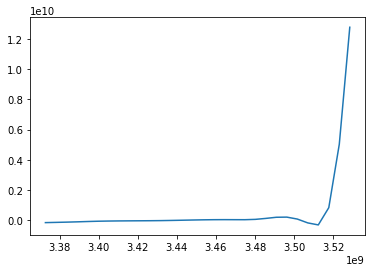

In [28]:
plt.plot(binm,V)

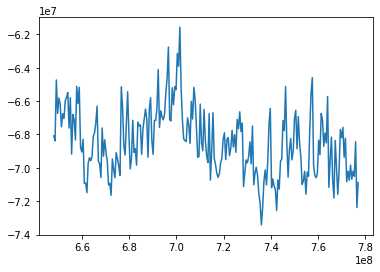

In [29]:
plt.plot(tcoor[24*50:24*60]/24*3600,F)

In [30]:
Ftot,binm,V = Landau.Landau_energy(RCE300.FMSE,N_bins=30,V_fixed=V,bin_fixed=binm)

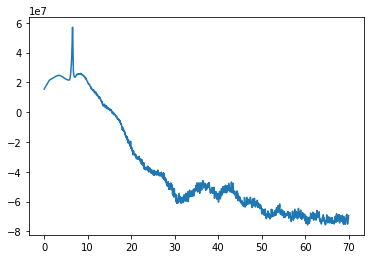

In [31]:
plt.plot(tcoor/(24*3600),Ftot)

### 2.1.2) Contours

In [41]:
def find_sepmin_bin(field,vmin=45,vmax=55,N_bins=30):
# Inputs
# field = field from which to take the pdf
# vmin = minimal value of the interval over which min(PDF) will be searched
# vmax = maximal value //
# bins = Number of bins of the PDF

    field_hist,bin_edges = np.histogram(field.flatten(),bins=N_bins)
    bin_mid = 0.5*(bin_edges[:-1]+bin_edges[1:])

    binary = (bin_mid<vmax)*(bin_mid>vmin)
    imin =  np.argmin(field_hist[binary])+np.argmax(binary)

    return bin_mid[imin],bin_mid

In [42]:
a,bin_m = find_sepmin_bin(RCE300.FMSE[24*50:24*60,:,:].values,vmin=3.4e9,vmax=3.5e9)

In [43]:
field_hist,bin_edges = np.histogram(RCE300.FMSE[24*50:24*60,:,:].values.flatten(),bins=30)
bin_mid = 0.5*(bin_edges[:-1]+bin_edges[1:])

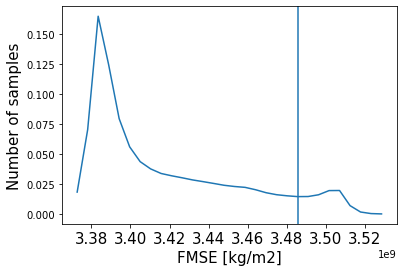

In [44]:
fz = 15

plt.figure()

ax = plt.subplot(111)
ax.plot(bin_mid,field_hist/np.sum(field_hist))
ax.axvline(x=a)
plt.xlabel('FMSE [kg/m2]',fontsize=fz)
plt.ylabel('Number of samples',fontsize=fz)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz) 

In [47]:
Contour = curv.get_contours(RCE300.FMSE[24*50,:,:]>a)

In [49]:
Contour.shape

(2,)

In [53]:
dx = 3.3e3
for i,contour in enumerate(Contour):
    L = np.sum(contour*dx)

In [64]:
CL = np.zeros((np.size(tcoor),))

for it,t in enumerate(tcoor):
    print('it=',it,'           ',end='\r')
    Contour = curv.get_contours(RCE300.FMSE[it,:,:]>\
                                np.median(RCE300.FMSE[it,:,:],axis=(0,1))[np.newaxis,np.newaxis],minLength=0)
    L = 0
    for i,contour in enumerate(Contour):
        L += np.sum(contour*dx)
    CL[it] = L

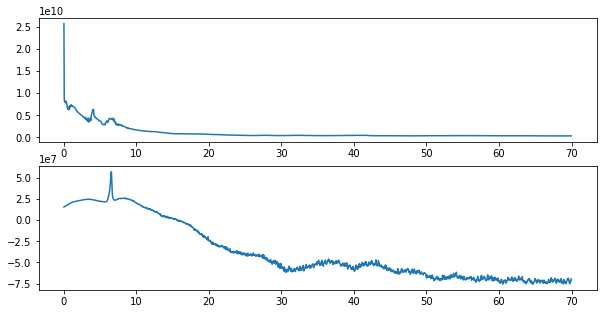

In [82]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(tcoor/(24*3600),CL)
plt.subplot(2,1,2)
plt.plot(tcoor/(24*3600),Ftot)

Text(0, 0.5, 'Ftot')

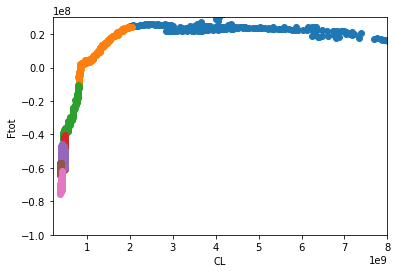

In [127]:
dt_plt = 9
for it in range(7):
    plt.scatter(CL[24*dt_plt*it:(24*dt_plt*(it+1))],Ftot[24*dt_plt*it:(24*dt_plt*(it+1))])
plt.xlim((2e8,8e9))
plt.ylim((-1e8,3e7))
plt.xlabel('CL')
plt.ylabel('Ftot')

In [100]:
def func(x,a,b):
    return a*x+b

In [103]:
popt,pcov = curve_fit(func, xdata=CL[24*15:24*30], ydata=Ftot[24*15:24*30])

In [104]:
popt

array([ 1.02367757e-01, -9.20521777e+07])

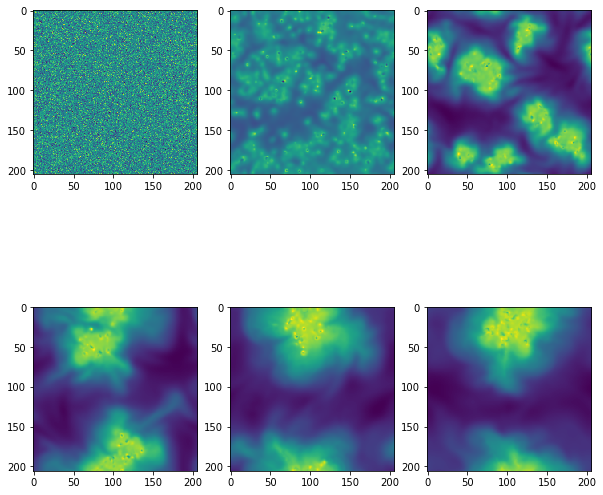

In [128]:
plt.figure(figsize=(10,10))
for it in range(6):
    plt.subplot(2,3,it+1)
    plt.imshow(RCE300.FMSE[24*dt_plt*it,:,:])

Day 9-16 and day 16-24 and day 24-rest  
Does advection contribute more to the potential in the second period  
dF = sum(dF) = sum([V])

### 2.1.3) Object-oriented approach to surface tension

In [129]:
bFMSE = np.where(RCE300.FMSE > np.median(RCE300.FMSE, axis=(1,2))[:, np.newaxis, np.newaxis], 1, 0)

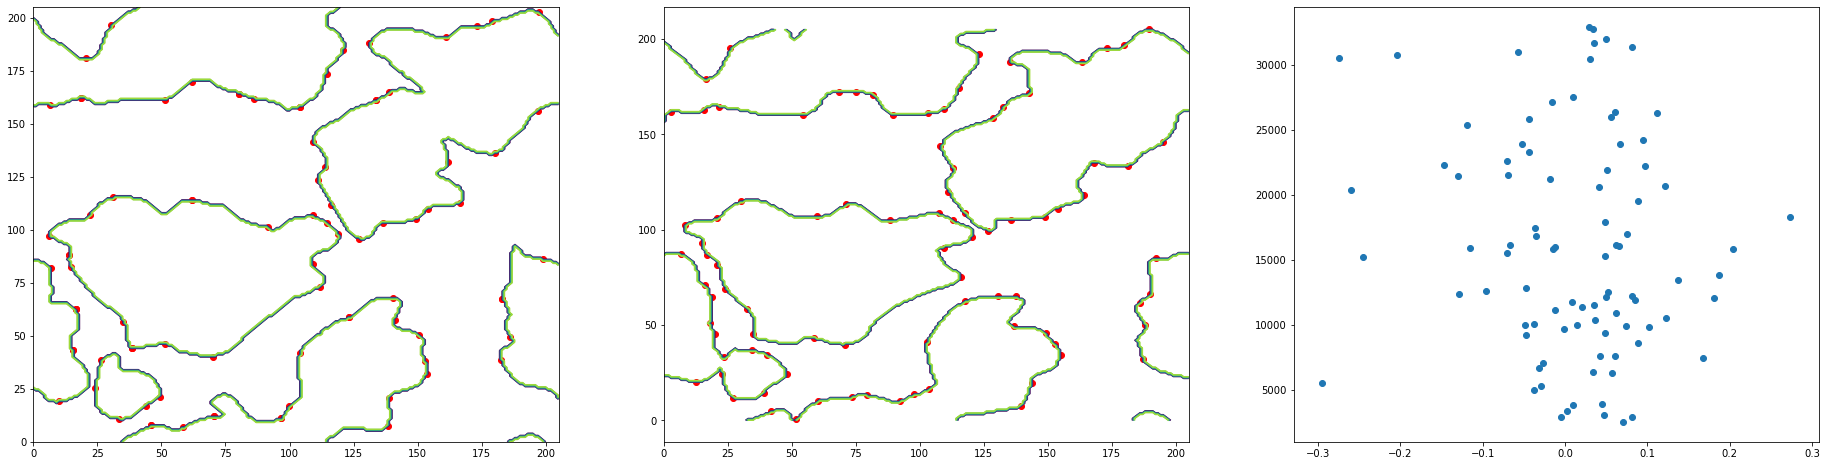

In [154]:
curvature, x, y, x_old, y_old, distance  = curve.distance_contour_extremas(bFMSE[16*24,:,:], bFMSE[15*24,:,:], dx=3300 )


fig = plt.figure(figsize=(32,8))

plt.subplot(1, 3, 1)
plt.contour(bFMSE[15*24,:,:])
plt.scatter(x_old,y_old, c = 'r')

#for en, extrem in enumerate(curvature):
#    circle = plt.Circle((x[en], y[en]), radius = 100 * curvature, facecolor='none', edgecolor='k')
#    ax.add_patch(circle)

plt.subplot(1, 3, 2)
plt.contour(bFMSE[16*24,:,:])
plt.scatter(x, y, c = 'r')

plt.subplot(1, 3, 3)
plt.scatter( curvature, distance)



   

/users/tbeucler/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/users/tbeucler/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/users/tbeucler/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


(0, 250)

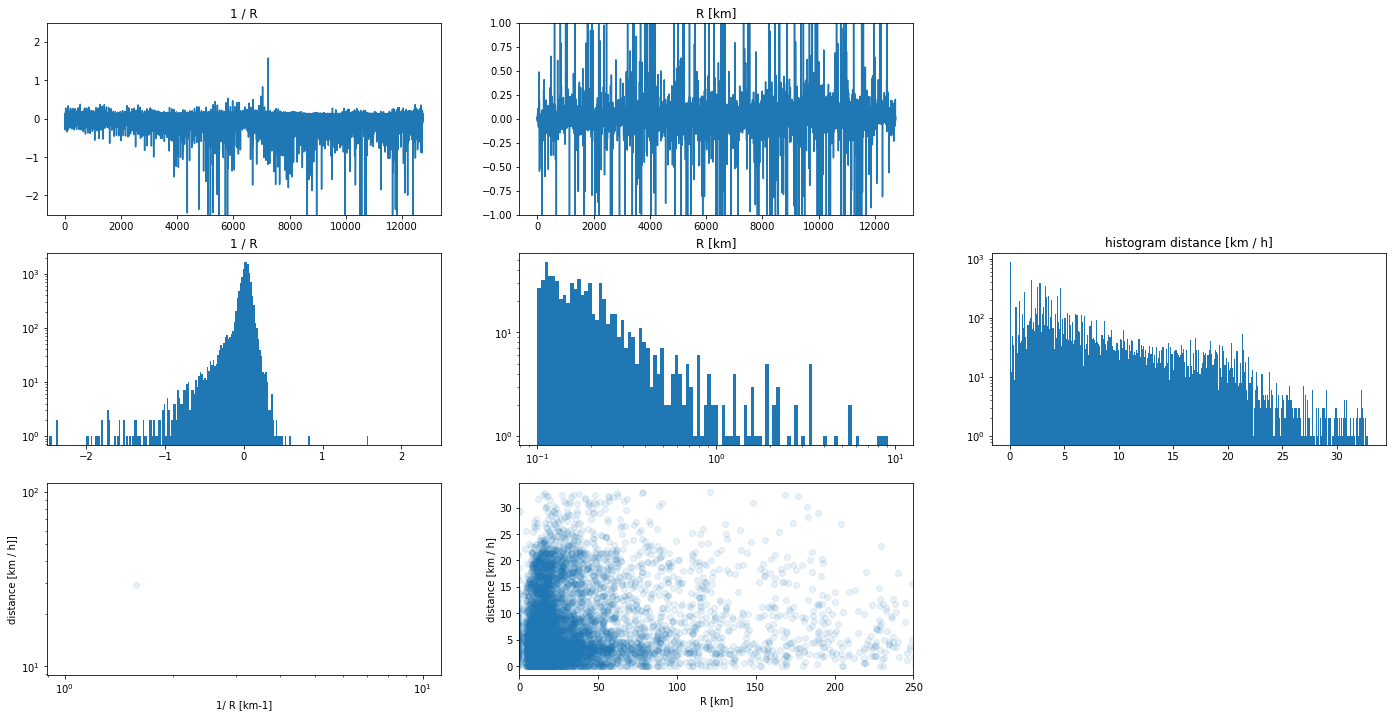

In [167]:

curvature = np.array([], float)
distance  = np.array([], float)

for t in range(16*24,24*24,1):
    curv, x, y, x_old, y_old, dist  = curve.distance_contour_extremas(bFMSE[t,:,:], bFMSE[t-1,:,:],  dx=3300)
    curvature = np.append(curvature, curv)
    distance = np.append(distance, dist)

fig = plt.figure(figsize=(24,12))

plt.subplot(3, 3, 1)
plt.plot(curvature)
plt.title('1 / R')
plt.ylim(-2.5,2.5)

plt.subplot(3, 3, 2)
plt.plot(1 / curvature / 1000)
plt.title('R [km]')
plt.ylim(-1, 1)

plt.subplot(3, 3, 4)
plt.hist(curvature, bins=1000)
plt.yscale('log')
plt.xlim(-2.5,2.5)
plt.title('1 / R')

plt.subplot(3, 3, 5)
plt.hist(1 / curvature / 1000, bins=np.logspace(np.log10(0.1),np.log10(10.0), 100))
plt.yscale('log')
plt.xscale('log')
#plt.xlim(-10000,10000)
plt.title('R [km]')

plt.subplot(3, 3, 6)
plt.hist(distance / 1000, bins=np.arange(0,np.amax(distance / 1000), 0.1 ))
plt.title('histogram distance [km / h]')
plt.yscale('log')

plt.subplot(3, 3, 7)
plt.scatter(curvature, distance / 1000, alpha=0.1)
plt.xlabel('1/ R [km-1]' )
plt.ylabel('distance [km / h]]')
plt.xscale('log')
plt.yscale('log')

plt.subplot(3, 3, 8)
plt.scatter(1 / curvature, distance / 1000, alpha=0.1)
plt.xlabel('R [km]')
plt.ylabel('distance [km / h]')
plt.xlim(0, 250)

(0, 0.5)

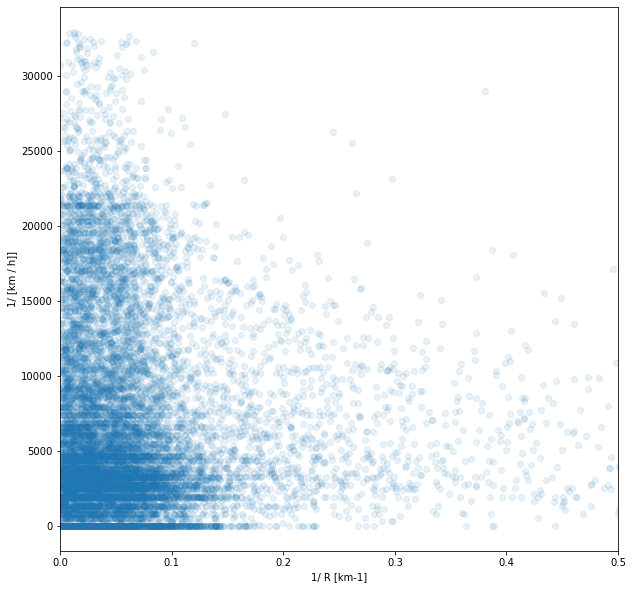

In [174]:
plt.figure(figsize=(10,10))
plt.scatter(np.abs(curvature), np.abs(distance), alpha=0.1)
plt.xlabel('1/ R [km-1]' )
plt.ylabel('1/ [km / h]]')
plt.xlim((0,0.5))
# plt.xscale('log')
# plt.yscale('log')

/users/tbeucler/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/users/tbeucler/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical left == right == 50 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.
/users/tbeucler/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Attempting to set identical bottom == top == 50 results in singular transformations; automatically expanding.
  # This is added back by InteractiveShellApp.init_path()


(47.5, 52.5)

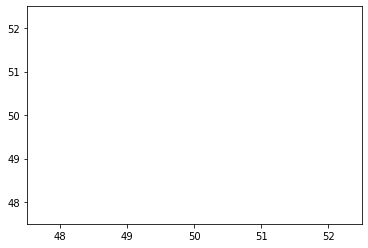

In [159]:

curvature = np.array([], float)
distance  = np.array([], float)

for t in range(9*24,16*24,1):
    curv, x, y, x_old, y_old, dist  = curve.distance_contour_extremas(bFMSE[t,:,:], bFMSE[t-1,:,:],  dx=3300)
    curvature = np.append(curvature, curv)
    distance = np.append(distance, dist)
    


(array([3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 3.0000e+00, 2.5000e+01, 7.8000e+02, 1.8178e+04]),
 array([-12.92218357, -11.51922653, -10.1162695 ,  -8.71331246,
         -7.31035543,  -5.90739839,  -4.50444135,  -3.10148432,
         -1.69852728,  -0.29557024,   1.10738679]),
 <a list of 10 Patch objects>)

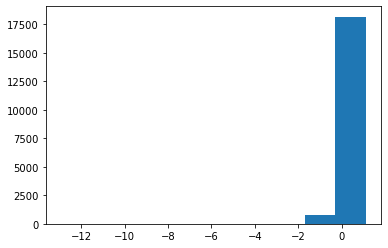

In [164]:
plt.hist(curvature)

/users/tbeucler/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


(-5, 5)

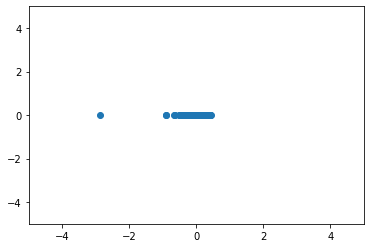

In [162]:
plt.scatter(curvature,distance/curvature)
plt.xlim((-5,5))
plt.ylim((-5,5))

## 2.2) PW

In [133]:
field_hist,bin_edges = np.histogram(RCE300.TQV[24*50:24*60,:,:].values.flatten(),bins=30)
bin_mid = 0.5*(bin_edges[:-1]+bin_edges[1:])